<h2>PaDiM: a Patch Distribution Modeling Framework for Anomaly Detection and Localization</h2>
<p>Research Paper: Source: <a href="https://arxiv.org/pdf/2011.08785.pdf">https://arxiv.org/pdf/2011.08785.pdf</a></p>
<p>Codebase Source: <a href="https://github.com/xiahaifeng1995/PaDiM-Anomaly-Detection-Localization-master">https://github.com/xiahaifeng1995/PaDiM-Anomaly-Detection-Localization-master</a></p>
<p>Implementation by <a href="http://www.seankim.kr/about">Sean Sungil Kim</a></p>
<br>

<p>
    <h3>Summary : </h3>
    <br>
    Anomaly detection is usually thought of a binary classification task (normal vs abnormal classes). The traditional machine learning classification tasks may require a lot of computation power in addition to resources such as time, cost, etc. The author of "PaDiM" proposes a method that utilizes pre-trained CNNs such as ResNet18 and Wide ResNet50 to assist in anomaly localization and detection. PaDiM's requirements for time, cost, and computational power are low and independent of the training dataset size, which is a huge benefit in industrial context.
</p>

<p>
    Simply put, the PaDiM algorithm is performing anomoly detection in images in one-class learning setting. One-class learning is when the training dataset contains only images from the <i>"normal class"</i> and anomalous examples are not available during the training. This is benefitial especially during deployment, since anomalous instances are rare.
</p>

<p>
    Due to the low resource requirement and the one-class learning aspect, PaDiM demonstrates superiority over other methods discussed in the paper (Reconstruction-based and Embedding similarity-based methods), not to mention the state-of-the-art performance. PaDiM looks attractive for industrial use.
</p>

<br>
<img src=https://github.com/xiahaifeng1995/PaDiM-Anomaly-Detection-Localization-master/raw/main/imgs/pic1.png>

<br>
<p>
    The pre-trained CNNs are used as a feature extraction method, to obtain the <i>"patch embedding vectors"</i>. For ResNet18 specifically, a hook is registered at the end of layer1, layer2, layer3 to extract detailed image features in different parts <i>(a.k.a. semantic levels)</i> of the convolutional network. Augmentations are performed on the input images, and these outputs from the hooks are simply concatenated to make the patch embedding vectors. When all N normal images are processed to obtain N patch embedding vectors, random selection is used to choose the embeddings as a dimensionality reduction procedure. It is important to notice that random selection is used to pick certain ares within the embeddings, not from the N number of embeddings. The height and the width dimensions are flattened as well. The mean and the covariance of the embedding vectors are computed; this is the learning of the multivariate Gaussian distribution with a specific set of parameters or the <i>"probabilistic representation of the normal class"</i>.
</p>

<p>
    During the training phase, the learned multivariate Gaussian distribution parameters are saved. The testing phase goes through the same process as well, and the training vs. testing parameters are compared to determine how similar the "normal" embedding vectors are from the testing. In order to measure the similarity between the normal and the abnormal multivariate Gaussian distribution, Mahalanobis distance function is used. Once the distance score array is obtained, a bicubic interpolation is performed to reshape the distance score array to the orignal size of the input image. A Gaussian filter with parameter σ = 4 is then performed, to generate the final anomaly map. High scores in this map indicate the anomalous areas, which performs the localization task as proposed. The final anomaly score of the entire image is the maximum of anomaly map, which can be used to classify the normal vs abnormal instances.
</p>
<br>

In [1]:
# sean sungil kim

import random
from random import sample
import numpy as np
import os
import pickle
import glob
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
from torchsummary import summary

<img src="https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png" width=400>
<p style="text-align:center">ResNet18 Architecture</p>
<br>
<img src="https://pytorch.org/assets/images/wide_resnet.png" width=400>
<p style="text-align:center">Wide-ResNet50 Architecture</p>
<br>

In [4]:
class PreProcess(Dataset):
    # Map-style datasets
    # A map-style dataset is one that implements the __getitem__() and __len__() protocols, 
    # and represents a map from (possibly non-integral) indices/keys to data samples.
    
    def __init__(self, data_path, class_name, is_train, resize=256, cropsize=224):
        self.data_path = data_path
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.cropsize = cropsize
        
        # load dataset
        self.data, self.y, self.mask = self.load_dataset_folder()

        # set augmentation transformations
        self.augmentation_data = T.Compose([T.Resize(resize, Image.ANTIALIAS),
                                            T.CenterCrop(cropsize),
                                            T.ToTensor(),
                                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.augmentation_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                            T.CenterCrop(cropsize),
                                            T.ToTensor()])
        
    def __len__(self):
        # necessary for DataLoader
        return len(self.data)

    def __getitem__(self, index):
        # necessary for DataLoader
        # generates one sample of data
        data, y, mask = self.data[index], self.y[index], self.mask[index]
        
        # load data as RGB and perform augmentations
        data = self.augmentation_data(Image.open(data).convert('RGB'))

        if y == 0:
            # initialize zero tensors
            mask = torch.zeros([1, self.cropsize, self.cropsize])
        else:
            # load the mask data and perform augmentations
            mask = self.augmentation_mask(Image.open(mask))

        return data, y, mask

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        data, y, mask = [], [], []

        img_dir = os.path.join(self.data_path, self.class_name, phase)
        gt_dir = os.path.join(self.data_path, self.class_name, 'ground_truth')

        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            img_type_dir = os.path.join(img_dir, img_type)

            if not os.path.isdir(img_type_dir):
                continue
                
            # obtain all data list
            img_fpath_list = sorted(glob.glob(os.path.join(img_type_dir, '*.png')))
            data.extend(img_fpath_list)

            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png') \
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        return list(data), list(y), list(mask)

In [5]:
# configurations

MODEL_ARCH  = 'resnet18'
SEED_ID     = 3314
DATA_PATH   = './DATA/'
SAVE_PATH   = './RESULTS/'
CLASS_NAMES = ['bottle']
#['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', \
#'toothbrush', 'transistor', 'wood', 'zipper']

def embedding_concat(patch_embedding_vectors, concat_vectors):
    # N images, C number of embedding vectors, height, width
    N, C1, H1, W1 = patch_embedding_vectors.size()
    _, C2, H2, W2 = concat_vectors.size()
    s = int(H1 / H2)
    
    # first adjust the dimension of the original patch_embedding_vectors to (N, -1, H2*W2)
    patch_embedding_vectors = F.unfold(patch_embedding_vectors, kernel_size=s, dilation=1, stride=s)

    # then adjust the dimension of the original patch_embedding_vectors to (N, C1, -1, H2, W2)
    # this is so that the concatenation could be performed on axis=2
    patch_embedding_vectors = patch_embedding_vectors.view(N, C1, -1, H2, W2)

    # initialize the final patch_embedding_vectors output
    concated_patch_embedding_vectors = torch.zeros(N, C1 + C2, patch_embedding_vectors.size(2), H2, W2)

    # replace the concated_patch_embedding_vectors values with actual concatenated values
    for i in range(patch_embedding_vectors.size(2)):
        concated_patch_embedding_vectors[:, :, i, :, :] = torch.cat((patch_embedding_vectors[:, :, i, :, :], concat_vectors), 1)

    # readjust the dimension of the concated_patch_embedding_vectors to (N, -1, H2*W2)
    # to reverse the fold operation
    concated_patch_embedding_vectors = concated_patch_embedding_vectors.view(N, -1, H2 * W2)

    # using the original H1 and W1 dimension,
    # adjust the dimension to obtain the resolution of the largest activation map
    # (due to the nature of the cnn layers, the earlier dimension size is bigger)
    concated_patch_embedding_vectors = F.fold(concated_patch_embedding_vectors, kernel_size=s, output_size=(H1, W1), stride=s)

    return concated_patch_embedding_vectors

def denormalize(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    
    return x

def visualize(test_imgs, scores, gt_mask, save_dir, class_name):
    os.makedirs(os.path.join(save_dir, class_name), exist_ok=True)
    for i in range(len(test_imgs)):
        test_img = denormalize(test_imgs[i])
        score_map = scores[i]
        mask = score_map.copy()
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        mask = morphology.opening(mask, morphology.disk(4))*255
        fin_result = mark_boundaries(test_img, mask, color=(1, 0, 0), mode='thick')
        
        res_fig, res_ax = plt.subplots(1, 4, figsize=(12, 3))
        res_ax[0].imshow(test_img), res_ax[0].title.set_text('Original Test Image')
        res_ax[1].imshow(gt_mask[i, 0], cmap='gray'), res_ax[1].title.set_text('Ground Truth')
        res_ax[2].imshow(score_map), res_ax[2].title.set_text('Predicted Anomaly Heatmap')
        res_ax[3].imshow(fin_result), res_ax[3].title.set_text('Final Result')
        res_fig.tight_layout()
        res_fig.savefig(os.path.join(save_dir, class_name, class_name + '_{}'.format(i)), dpi=100)

/home/sik/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
Testing Phase - Class = bottle: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Image-level ROCAUC : 0.9976
Pixel-level ROCAUC : 0.9810


Overall Results :
Average image-levelROCAUC : 0.998
Average pixel ROCUAC : 0.981


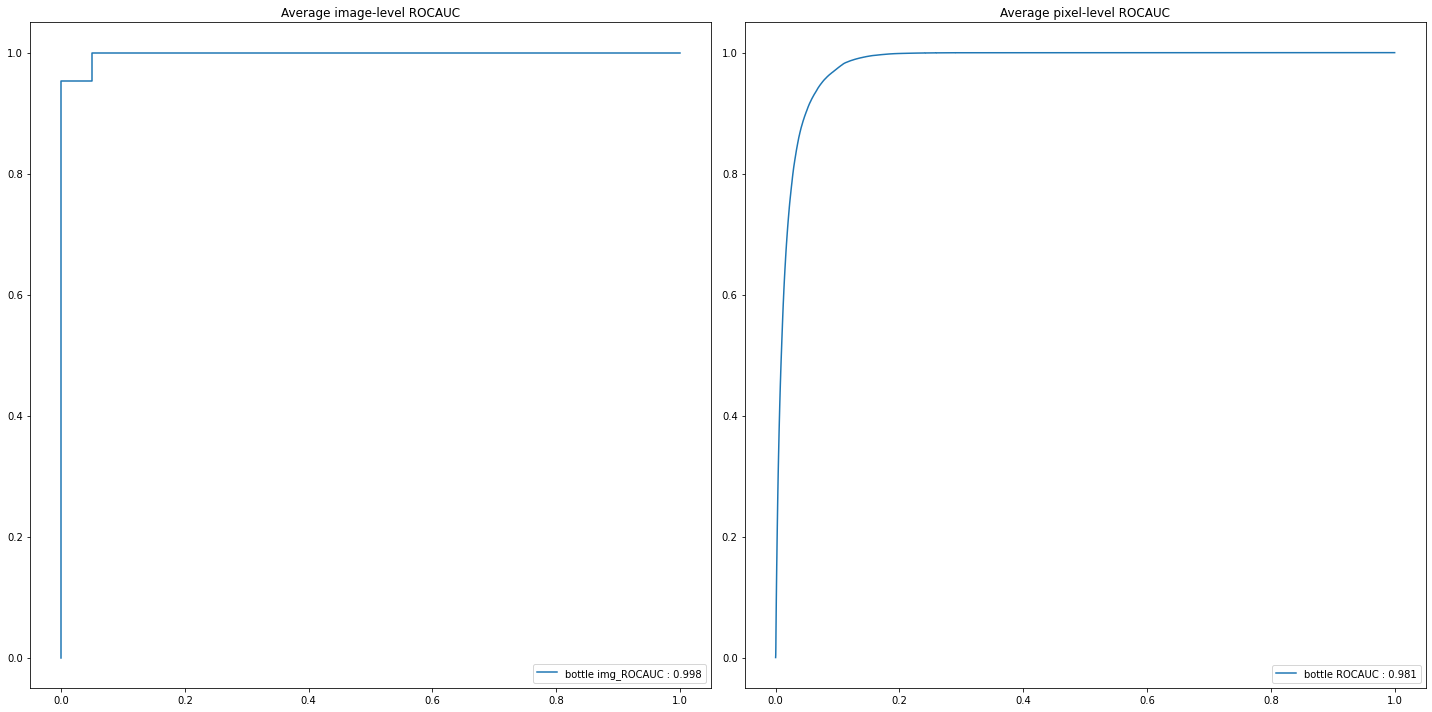

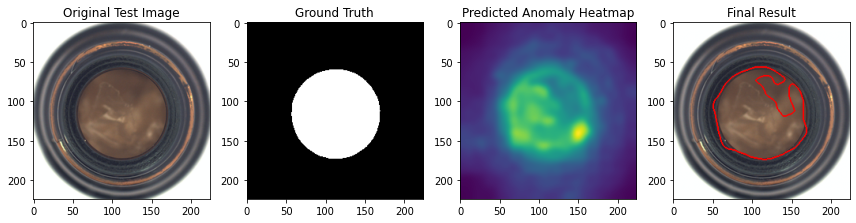

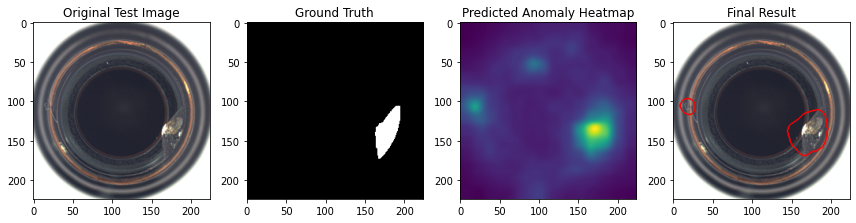

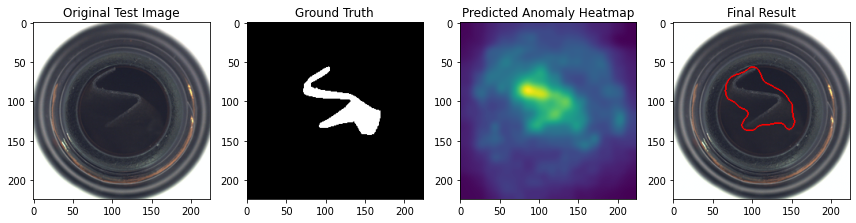

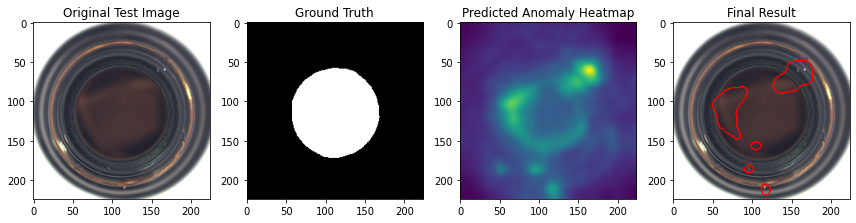

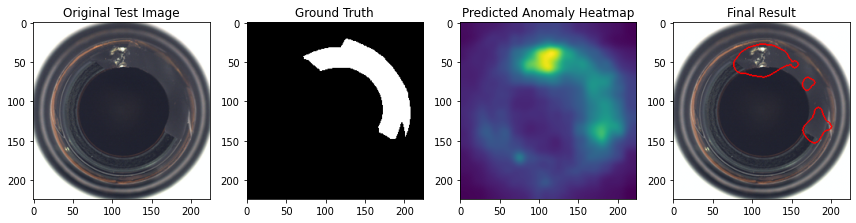

In [6]:
# load pretrained CNNs
if MODEL_ARCH == 'resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = int(t_d/4)
elif MODEL_ARCH == 'wide_resnet50_2':
    model = wide_resnet50_2(pretrained=True, progress=True)
    t_d = 1792
    d = int(t_d/4)

model.to('cpu')
model.eval()
random.seed(SEED_ID), torch.manual_seed(SEED_ID)
idx = random.sample(range(1, t_d), d)

# register the hook to extract patch embedding vectors
outputs = []

# ROCAUC result list
total_img_roc_auc = []
total_pixel_roc_auc = []

def hook(module, input, output):
    outputs.append(output)

model.layer1[-1].register_forward_hook(hook) # last layer of layer 1
model.layer2[-1].register_forward_hook(hook) # last layer of layer 2
model.layer3[-1].register_forward_hook(hook) # last layer of layer 3

os.makedirs(os.path.join(SAVE_PATH, 'temp_%s' % MODEL_ARCH), exist_ok=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig_img_rocauc = ax[0]
fig_pixel_rocauc = ax[1]

for class_name in CLASS_NAMES:
    # data.shape = N images, rgb (color channel), height, width
    # y.shape    = N images
    # mask.shape = N images, grayscale (color channel), height, width
    train_dataloader = DataLoader(PreProcess(DATA_PATH, class_name=class_name, is_train=True), \
                                  batch_size=32, pin_memory=True)
    
    # initialize the layer output dictionary
    train_outputs = {'layer1' : torch.empty(0), 'layer2' : torch.empty(0), 'layer3' : torch.empty(0)}
    
    # features directory
    train_feature_filepath = os.path.join(SAVE_PATH, 'temp_%s' % MODEL_ARCH, 'train_%s.pkl' % class_name)
    
    # training phase
    if not os.path.exists(train_feature_filepath):
        for data, _, _ in tqdm(train_dataloader, 'Trainng Phase - Class = %s' % (class_name)):
            # input the augmented image data in the pre-trained model
            with torch.no_grad():
                _ = model(data.to('cpu'))
            
            # concatenate layer outputs to obtain the patch embedding vectors
            for key, output in zip(train_outputs.keys(), outputs):
                train_outputs[key] = torch.cat((train_outputs[key], output.cpu().detach()), 0)

            # reset the hook outputs
            outputs = []
        
        # concat patch embedding vectors
        for key in train_outputs.keys():
            patch_embedding_vectors = train_outputs[key] if key == 'layer1' else embedding_concat(patch_embedding_vectors, train_outputs[key])
        
        # random selection (dimensionality reduction)
        patch_embedding_vectors = patch_embedding_vectors[:, idx]
        
        # reduce the dimension to obtain the shape (N, number of embedding vectors, height * width)
        N, C, H, W = patch_embedding_vectors.size()
        patch_embedding_vectors = patch_embedding_vectors.view(N, C, H * W)
        
        # learn the multivariate Gaussian distribution parameters, via axis=0
        mean = torch.mean(patch_embedding_vectors, dim=0).numpy()
        cov = np.zeros((C, C, H*W))
        I = np.identity(C)
        for i in range(H * W):
            cov[:, :, i] = np.cov(patch_embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
        
        # save the learned multivariate Gaussian distribution parameters
        train_outputs = [mean, cov]
        with open(train_feature_filepath, 'wb') as f:
            pickle.dump(train_outputs, f)
            
    else:
        print('Loading the learned multivariate Gaussian distribution parameters - Class = %s' % class_name)
        with open(train_feature_filepath, 'rb') as f:
            train_outputs = pickle.load(f)
            
    gt_list = []
    gt_mask_list = []
    test_imgs = []

    # data.shape = N images, rgb (color channel), height, width
    # y.shape    = N images
    # mask.shape = N images, grayscale (color channel), height, width
    test_dataloader = DataLoader(PreProcess(DATA_PATH, class_name=class_name, is_train=False), \
                                 batch_size=32, pin_memory=True)
    
    # initialize the layer output dictionary
    test_outputs  = {'layer1' : torch.empty(0), 'layer2' : torch.empty(0), 'layer3' : torch.empty(0)}
    
    # testing phase
    for (data, y, mask) in tqdm(test_dataloader, 'Testing Phase - Class = %s' % class_name):
        test_imgs.extend(data.cpu().detach().numpy())
        gt_list.extend(y.cpu().detach().numpy())
        gt_mask_list.extend(mask.cpu().detach().numpy())
        
        # input the augmented test image data in the pre-trained model
        with torch.no_grad():
            _ = model(data.to('cpu'))
            
        # concatenate layer outputs to obtain the patch embedding vectors
        for key, output in zip(test_outputs.keys(), outputs):
            test_outputs[key] = torch.cat((test_outputs[key], output.cpu().detach()), 0)
        
        # reset the hook outputs
        outputs = []
        
    # concat patch embedding vectors
    for key in test_outputs.keys():
        patch_embedding_vectors = test_outputs[key] if key == 'layer1' else embedding_concat(patch_embedding_vectors, test_outputs[key])

    # random selection (dimensionality reduction)
    patch_embedding_vectors = patch_embedding_vectors[:, idx]
    
    # reduce the dimension to obtain the shape (N, number of embedding vectors, height * width)
    N, C, H, W = patch_embedding_vectors.size()
    patch_embedding_vectors = patch_embedding_vectors.view(N, C, H * W)
    
    # generate the distance score array
    dist_list = []
    for i in range(H * W):
        mean = train_outputs[0][:, i]
        conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
        dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in patch_embedding_vectors]
        dist_list.append(dist)
    dist_list = np.array(dist_list).transpose(1, 0).reshape(N, H, W)
    
    # bicubic interpolation on the distance score array to generate the anomaly map
    # high scores in this anomaly map indicate the anomalous areas
    dist_list = torch.tensor(dist_list)
    score_map = F.interpolate(dist_list.unsqueeze(1), size=data.size(2), mode='bilinear',
                              align_corners=False).squeeze().numpy()

    # Gaussian filter with parameter σ = 4 on the anomaly map
    for i in range(score_map.shape[0]):
        score_map[i] = gaussian_filter(score_map[i], sigma=4)

    # Min-max Normalization on the anomaly map
    max_score = score_map.max()
    min_score = score_map.min()
    scores = (score_map - min_score) / (max_score - min_score)

    # the final anomaly score of the entire image is the maximum of anomaly map
    # this can be used to classify normal vs abnormal
    img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
    
    # image-level ROCAUC
    gt_list = np.asarray(gt_list)
    fpr, tpr, _ = roc_curve(gt_list, img_scores)
    img_rocauc = roc_auc_score(gt_list, img_scores)
    total_img_roc_auc.append(img_rocauc)
    print('Image-level ROCAUC : %.4f' % (img_rocauc))
    fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC : %.3f' % (class_name, img_rocauc))

    # get optimal threshold
    gt_mask = np.asarray(gt_mask_list)
    precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
    a = 2 * precision * recall
    b = precision + recall
    f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
    threshold = thresholds[np.argmax(f1)]

    # pixel-level ROCAUC
    fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
    pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
    total_pixel_roc_auc.append(pixel_rocauc)
    print('Pixel-level ROCAUC : %.4f' % (pixel_rocauc))
    fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC : %.3f' % (class_name, pixel_rocauc))
    
    # visualize the test result, randomly select 5 instances
    test_idx = random.sample(range(1, len(scores)), 5)
    fin_scores = scores[test_idx]
    fin_test_imgs = np.array(test_imgs)[test_idx]
    fin_mask = gt_mask[test_idx]
    visualize(fin_test_imgs, fin_scores, fin_mask, SAVE_PATH, class_name)
    
print('\n\nOverall Results :')
print('Average image-levelROCAUC : %.3f' % np.mean(total_img_roc_auc))
print('Average pixel ROCUAC : %.3f' % np.mean(total_pixel_roc_auc))

fig_img_rocauc.title.set_text('Average image-level ROCAUC')
fig_pixel_rocauc.title.set_text('Average pixel-level ROCAUC')
fig_img_rocauc.legend(loc=4), fig_pixel_rocauc.legend(loc=4), fig.tight_layout()
fig.savefig(os.path.join(SAVE_PATH, 'rocauc_curve.png'))